***Nome/Alaska Meteo Data Processing Script*** <br /> 
This script processes meteo data from [NCDC NOAA](https://www.ncdc.noaa.gov/cdo-web/).<br /> 
Data units could be found in this [document](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf).<br />
The standard wind measurement hieght is [1.5 m](https://www.ncdc.noaa.gov/crn/measurements.html).<br />
EJ 01/30/17<br />

***Data Types*** <br /> 
WSF2 - Fastest 2-minute wind speed <br /> 
FMTM - Time of fastest mile or fastest 1-minute wind <br /> 
WSF5 - Fastest 5-second wind speed <br /> 
SNOW - Snowfall <br /> 
WDFG - Direction of peak wind gust <br /> 
PRCP - Precipitation <br /> 
TOBS - Temperature at the time of observation <br /> 
MXPN - Daily maximum temperature of water in an evaporation pan <br /> 
SNWD - Snow depth <br /> 
WSF1 - Fastest 1-minute wind speed <br /> 
WDF1 - Direction of fastest 1-minute wind <br /> 
WDF2 - Direction of fastest 2-minute wind <br /> 
AWND - Average wind speed <br /> 
WDF5 - Direction of fastest 5-second wind <br /> 
PGTM - Peak gust time <br /> 
WSFG - Peak gust wind speed <br /> 
TMAX - Maximum temperature <br /> 
WESD - Water equivalent of snow on the ground <br /> 
TAVG - Average Temperature. <br /> 
TMIN - Minimum temperature <br /> 
MDPR - Multiday precipitation total (use with DAPR and DWPR, if available) <br /> 
WDMV - Total wind movement <br /> 

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def process_data(data,var_id,plt_title):
    # This  function works with daily averaged data, preparing it for the h5 file
    # NOTE: for TAVG its assumes that TMIN and TMAX are not missing
    print plt_title
    var=data[var_id]
    plt.subplot(311)
    plt.hist(var); plt.title(plt_title)
    n=len(var)
    print 'data legth:',n
    print 'min:',min(var), ', max=', max(var), \
                    ', mean=', ("%0.2f"%np.mean(var))

    if var_id=='TAVG':
        #if histograms shows that we have -9999 for TAVG, then we substitute these numbers with (TMIN+TMAX)/2
        data.loc[data['TAVG']==-9999,'TAVG']= \
                           (data.loc[data['TAVG']==-9999,'TMIN'] \
                           +data.loc[data['TAVG']==-9999,'TMAX'])/2
        var=data['TAVG']
    else:
        #If data has a negative values we going to zero them out 
        data.loc[var<0,var_id]=0
         
    plt.subplot(312)
    plt.hist(var); plt.title('Corrected '+plt_title)
    
    #convert data units
    if var_id=='AWND':
        plt_title=r'Average wind [AWND] (m/s)'
        var=var*1609.34/3600 #mph to mps
    
    if var_id=='PRCP':
        plt_title=r'Precipitation (m/s)'
        var=var*0.0254/86400 #inch per day to mm per second    
        
    elif var_id=='TAVG':
        plt_title=r'TAVG (K)'
        var=(var + 459.67) * 5/9 # F to K
    
    elif var_id=='SNOW':
        plt_title=r'Snowfall (m SWE /s)'
        var=var*0.0254/86400 #sinch per day to mm per second 
         
    plt.subplot(313)
    time=range(0,n)
    plt.xlabel('Days'), plt.ylabel(plt_title)
    z = np.polyfit(time, var, 1); poly = np.poly1d(z); y = poly(time)    
    print 'slope:',("%0.4f"%z[0]),', intersection:',("%0.2f"%z[1])
    plt.plot(time,var,'b',time,y,'r'); plt.title(plt_title)
    plt.tight_layout()
    plt.show()
    
    return var

Load the meteorological data to from NCDC NOAA

In [3]:
nome = pd.read_csv('Nome_1900_2017.csv') 

Quick look at the data 

In [4]:
nome.head()

,STATION,STATION_NAME,DATE,MXPN,MDPR,PRCP,SNWD,SNOW,TAVG,TMAX,...,WDF2,WDF5,WDFG,WSF1,WSF2,WSF5,PGTM,WSFG,FMTM,WDMV
0,GHCND:USW00026617,NOME MUNICIPAL AIRPORT AK US,19000801,-9999,-9999.0,0.0,-9999.0,-9999.0,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999,-9999.0
1,GHCND:USW00026617,NOME MUNICIPAL AIRPORT AK US,19000802,-9999,-9999.0,0.0,-9999.0,-9999.0,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999,-9999.0
2,GHCND:USW00026617,NOME MUNICIPAL AIRPORT AK US,19000803,-9999,-9999.0,0.0,-9999.0,-9999.0,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999,-9999.0
3,GHCND:USW00026617,NOME MUNICIPAL AIRPORT AK US,19000804,-9999,-9999.0,0.0,-9999.0,-9999.0,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999,-9999.0
4,GHCND:USW00026617,NOME MUNICIPAL AIRPORT AK US,19000805,-9999,-9999.0,0.0,-9999.0,-9999.0,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999,-9999.0


Choose the time interval 

In [5]:
time_beg=20070101; time_end=20161231
nome_slice=nome[(nome['DATE']>=time_beg)&(nome['DATE']<=time_end)]

Analyse PRCP, TAVG, AWND, SNWD and SNOW variables for missing values and convert untis

Average wind [AWND] (mph)
data legth: 3653
min: -9999.0 , max= 35.6 , mean= 0.37


/Users/elchin/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


slope: 0.0002 , intersection: 3.50


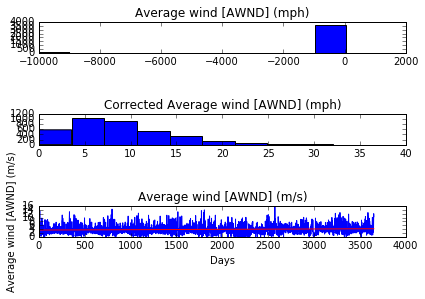

In [6]:
wind=process_data(nome_slice,'AWND',r'Average wind [AWND] (mph)')

Temperature (F)
data legth: 3653
min: -9999 , max= 70 , mean= -6234.21
slope: 0.0012 , intersection: 268.63


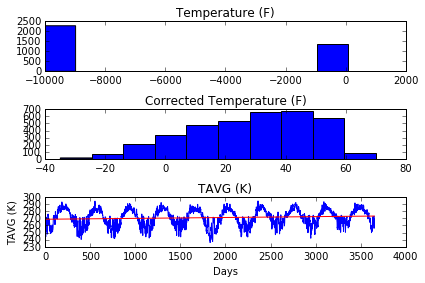

In [7]:
Tair=process_data(nome_slice,'TAVG',r'Temperature (F)')

Snow depth [SNWD] (cm)
data legth: 3653
min: 0.0 , max= 90.0 , mean= 9.14
slope: -0.0035 , intersection: 15.48


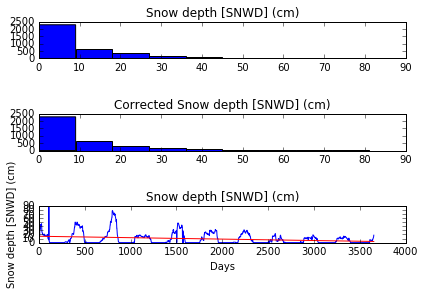

In [8]:
snd=process_data(nome_slice,'SNWD',r'Snow depth [SNWD] (cm)')

Snowfall (inch)
data legth: 3653
min: 0.0 , max= 15.5 , mean= 0.21
slope: -0.0000 , intersection: 0.00


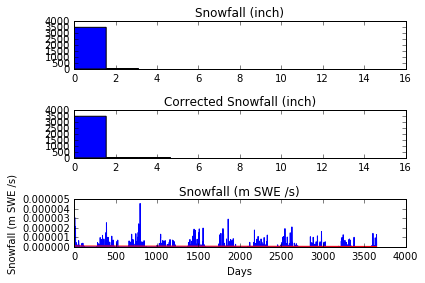

In [9]:
snow_fall=process_data(nome_slice,'SNOW',r'Snowfall (inch)');

Precipitation (inch)
data legth: 3653
min: 0.0 , max= 1.43 , mean= 0.04
slope: 0.0000 , intersection: 0.00


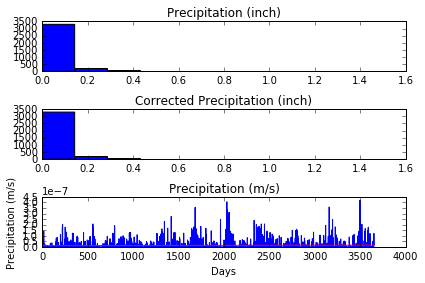

In [10]:
precip=process_data(nome_slice,'PRCP',r'Precipitation (inch)')

Finally we need to separate rain precipitation from snowfall. We do that in a crude way, not accounting for temperature correlations. If snowfall data is not correct this is going to affect the 'summer' rain.  

In [11]:
precip.loc[snow_fall>0]= 0

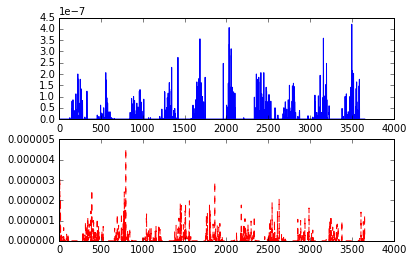

In [12]:
plt.subplot(211)
plt.plot(range(0,3653),precip); 
plt.subplot(212)
plt.plot(range(0,3653),snow_fall,'--r');

Now we have Tair, wind, snow_fall, and rain (precip). So we can setup the h5 file

In [ ]:
import h5py

In [13]:
fdat=u"../Barrow_Alaska/spinup-10yr.h5"
ddat = h5py.File(fdat, 'r')

NameError: name 'h5py' is not defined

In [ ]:
print ddat.keys()

In [ ]:
len(ddat['air temperature [K]'][:])
len(precip[0:3650])

Create new data file

In [ ]:
ff = h5py.File("10yr-Nome_data.h5",'w')

We do not have short and long wave radiation, and humidity data, so we are going to use them from the old Barrow file. 

In [ ]:
lr=ddat['incoming longwave radiation [W m^-2]'][:]
sr=ddat['incoming shortwave radiation [W m^-2]'][:]
rh=ddat['relative humidity [-]'][:]
time=ddat['time [s]'][:]

In [ ]:
ff.create_dataset("air temperature [K]",data=Tair[0:3650].values)
ff.create_dataset("incoming longwave radiation [W m^-2]",data=lr)
ff.create_dataset("incoming shortwave radiation [W m^-2]",data=sr)
ff.create_dataset("precipitation rain [m s^-1]",data=precip[0:3650].values)
ff.create_dataset("precipitation snow [m SWE s^-1]",data=snow_fall[0:3650].values)
ff.create_dataset("relative humidity [-]",data=rh )
ff.create_dataset("time [s]",data=time)
ff.create_dataset("wind speed [m s^-1]",data=wind[0:3650].values)
ff.keys()

In [ ]:
ff.close()